In [295]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import keras
from keras.models import Sequential, load_model
from plot_conf import *
import shelve
import h5py
import math

In [577]:
basepath = '/Users/theoglauch/slimfast/NN_Reco/train_hist/2017-08-19/charge_time_large_NN'
plot_data = np.load(os.path.join(basepath, 'test_res.npy'))
xbins = np.linspace(1.5,7,40)
ybins = np.linspace(0,9,50)
resolution=[]
binmids_x = [(xbins[i+1]+xbins[i])/2 for i in range(len(xbins)-1)]
binmids_y = [(ybins[i+1]+ybins[i])/2 for i in range(len(ybins)-1)]

In [578]:
x=np.log10(plot_data['depositedE_truth'])
y=[np.log10(plot_data['muex_truth']), plot_data['depositedE']] 
save_names= ['MuEx', 'DLReco']

In [583]:
which = 0

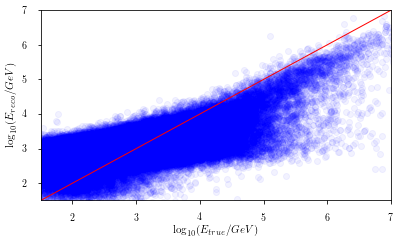

In [584]:
fig, ax= newfig(0.9)
ax.scatter(x, y[which], color='blue', alpha= 0.05)
ax.plot(xbins, xbins, color='red')
ax.set_xlabel(r'$\log_{10}(E_{true}/GeV)$')
ax.set_ylabel(r'$\log_{10}(E_{reco}/GeV)$')
ax.set_xlim(xbins[0],xbins[-1])
ax.set_ylim(ybins[0],ybins[-1])
ax.set_ylim(1.5,7)
ax.set_xlim(1.5,7)
plt.savefig('{}_scatter.png'.format(save_names[which]), dpi=300)
plt.show()

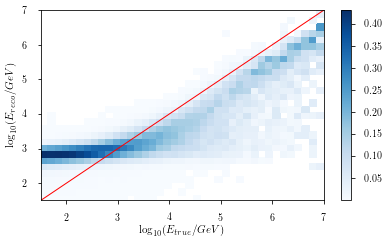

In [585]:
H, xedges, yedges = np.histogram2d(x,
                                   y[which], 
                                   bins=(xbins, ybins))
H=np.array([np.array(i)/np.sum(i) if np.sum(i)!= 0 else np.zeros(len(i)) for i in H ])
H = H.T  # Let each row list bins with common y range.
fig, ax = newfig(0.9)
X, Y = np.meshgrid(xedges, yedges)
ax.plot(xbins,
        xbins,
        color='red')

plot_H= np.ma.array(H)
plot_H.mask = (plot_H == 0) | (plot_H>1.0)
cbar = ax.pcolormesh(X, Y, plot_H, cmap=plt.get_cmap('Blues'))
plt.colorbar(cbar)
ax.set_xlabel(r'$\log_{10}(E_{true}/GeV)$')
ax.set_ylabel(r'$\log_{10}(E_{reco}/GeV)$')
ax.set_ylim(1.5,7)
ax.set_xlim(1.5,7)
plt.savefig('{}_PDF.png'.format(save_names[which]), dpi=300)
plt.show()




In [589]:
temp_resolution = []
for i, binmid in enumerate(binmids_x):
    average = np.average(binmids_y, weights=H.T[i])
    std = math.sqrt(np.average((binmids_y-average)**2, weights=H.T[i]))
    temp_resolution.append(std/binmid)
resolution.append((save_names[which],temp_resolution))

# Execute after all Recos have been appended

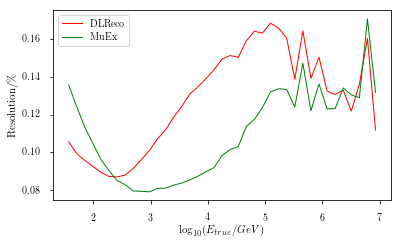

In [587]:
fig, ax= newfig(0.9)
for reco in resolution:
    ax.plot(binmids_x, reco[1], label=reco[0])
    ax.set_xlabel(r'$\log_{10}(E_{true}/GeV)$')
    ax.set_ylabel(r'Resolution/\%')
plt.legend(loc='best')
plt.savefig('resolution.png')

In [524]:
print resolution

[('MuEx', [0.056634444634889522, 0.053289641270953272, 0.049791181642050188, 0.047938389277364567, 0.046653920661115615, 0.044843598351602884, 0.044943750717655329, 0.044671264436273964, 0.045520711201281212, 0.045285464995976486, 0.046200541341691506, 0.046462512434365229, 0.047167461936634923, 0.048547085854485812, 0.0496057697968975, 0.050324057674267335, 0.051559281406409266, 0.055270259727809558, 0.055450189358413365, 0.057187983673016501, 0.061895691685063627, 0.064586070282067268, 0.067501245518783642, 0.068386486820964432, 0.074189025008439186, 0.075463609704612356, 0.073247667914194972, 0.069815510485600807, 0.08192523664894423, 0.06937849859841913, 0.073806226619238191, 0.072550841396039414, 0.071769893539726792, 0.065501114202709015, 0.074198622130699596, 0.075126020657400913, 0.075739969524137668, 0.099801681978416268, 0.041324311282431692]), ('DL_Reco', [0.050499920943318601, 0.049906795089606056, 0.049068269267750715, 0.049419660815663659, 0.049959307560227893, 0.05199456

# IceCube MuEx Reco

In [15]:
infiles = ['11029_00000-00999.h5','11029_01000-01999.h5','11029_02000-02999.h5','11029_03000-03999.h5']
xbins = np.linspace(2,7,30)
ybins = np.linspace(2,7,30)

In [16]:
H = np.zeros((29,29))
for infile in infiles:
    data = h5py.File('./training_data/{}'.format(infile))
    H_temp, _, _ = np.histogram2d(np.concatenate(np.log10(data['reco_vals'][:,0:1])), 
                                       np.concatenate(np.log10(data['reco_vals'][:,3:4])),
                                       bins=(xbins, ybins))
    H += H_temp
    

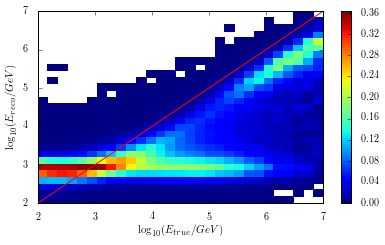

In [17]:
H=np.array([np.array(i)/np.sum(i) for i in H])
H = H.T  # Let each row list bins with common y range.
fig, ax = newfig(0.9)
X, Y = np.meshgrid(xbins, ybins)
ax.plot(np.linspace(2,7,10), np.linspace(2,7,10),color='red')
H= np.ma.array(H)
H.mask = H == 0
X, Y = np.meshgrid(xbins, ybins)
cbar = ax.pcolormesh(X, Y, H)
plt.colorbar(cbar)
ax.set_xlabel(r'$\log_{10}(E_{true}/GeV)$')
ax.set_ylabel(r'$\log_{10}(E_{reco}/GeV)$')
plt.savefig('muex.png')
plt.show()

In [187]:
test = [[] for i in range(2)]

In [191]:
test[1].extend([1,2])

In [192]:
print test

[[1, 2], [1, 2, 1, 2]]


In [469]:
a = []

In [474]:
a.append(([1,2],2))

In [475]:
print a

[(1, 2), (1, 2), ([1, 2], 2)]
